In [1]:
# %pip install davos

import davos
davos.config.suppress_stdout = False

In [2]:
from matplotlib smuggle pyplot as plt                      # pip: matplotlib==3.6.2
smuggle matplotlib as mpl
from statannotations.Annotator smuggle Annotator           # pip: statannotations==0.6
smuggle statsmodels as sm                                  # pip: statsmodels==0.14.0

smuggle numpy as np                                        # pip: numpy==1.22.3
smuggle pandas as pd                                       # pip: pandas==1.5.1
smuggle seaborn as sns                                     # pip: seaborn==0.12.1
smuggle dill as pickle                                     # pip: dill==0.3.6

smuggle h5py                                               # pip: h5py==3.7.0
smuggle deepdish                                           # pip: deepdish==0.3.7
smuggle pathos                                             # pip: pathos==0.3.0
smuggle quail                                              # pip: git+https://github.com/ContextLab/quail.git@0f4af91
smuggle requests                                           # pip: requests==2.28.1
smuggle os
smuggle warnings
smuggle string
smuggle itertools
from copy smuggle deepcopy

from tqdm smuggle tqdm                                     # pip: tqdm==4.64.1
from matplotlib.ticker smuggle MaxNLocator
from pathos.multiprocessing smuggle ProcessingPool as Pool # pip: pathos==0.3.0
from multiprocessing smuggle cpu_count                     # pip: multiprocess==0.70.14
from sklearn.decomposition smuggle IncrementalPCA as PCA   # pip: scikit-learn==1.1.3

# local functions
from dataloader import datadir, grouping, feature_groupings, descriptions, sort_by_grouping, fetch_data
from analyze import analyze_data, recover_fingerprint_features, organize_by_listgroup, random, adaptive, non_adaptive_exclude_random, \
                    select_conds, select_lists, filter, get_diffs, stack_diffs, pnr_matrix, accuracy2df, adaptive_listnum2cond, \
                    clustering_matrices, average_by_cond, rename_features, fingerprint2temporal, get_boundaries, \
                    recall_accuracy_near_boundaries, results, results_by_list, analyses, listgroups, orders, \
                    create_clustering_df, compute_temporally_corrected_fingerprints
from plot import combo_lineplot, colors, plot_heatmaps, accuracy_by_list, fingerprint_scatterplot_by_category, combo_fingerprint_plot, \
                    plot_features, figdir, plot_trajectories, plot_accuracy_near_boundaries, plot_boundary_density_maps, barplot_helper

  Cloning https://github.com/ContextLab/quail.git (to revision 0f4af91) to /private/var/folders/tp/qtzc39jx5w556wl5w3dj21wr0000gn/T/pip-req-build-tfn2wfmt
  Running command git clone --filter=blob:none --quiet https://github.com/ContextLab/quail.git /private/var/folders/tp/qtzc39jx5w556wl5w3dj21wr0000gn/T/pip-req-build-tfn2wfmt
  Running command git checkout -q 0f4af91
  Resolved https://github.com/ContextLab/quail.git to commit 0f4af91
  Preparing metadata (setup.py) ... done
loading data..............done!
basic analyses...


  0%|          | 0/5 [00:00<?, ?it/s]

starting fingerprint analysis for condition feature rich...
finished fingerprint analysis for condition feature rich
starting fingerprint analysis for condition category...
finished fingerprint analysis for condition category
starting fingerprint analysis for condition color...
finished fingerprint analysis for condition color
starting fingerprint analysis for condition length...
finished fingerprint analysis for condition length
starting fingerprint analysis for condition first letter...
finished fingerprint analysis for condition first letter
starting fingerprint analysis for condition location...
finished fingerprint analysis for condition location
starting fingerprint analysis for condition reduced (early)...


# Note: 

The analysis I've added to controlling for temporal clustering is potentially biased *away* from feature clustering.  For example, suppose that a list
is ordered along feature dimension $x$.  If the participant is *truly* clustering along feature dimension $x$, they will show *both* temporal and feature clustering.
And if we normalize for temporal clustering, we'll get rid of *both* temporal and feature clustering.

Another tricky point relates to semantic clustering.  When we "control" for temporal clustering, many participants still exhibit semantic clustering (category/size).
But is this driven by the experimental condition, or participants' innate tendencies?  One could imagine controlling for semantic clustering in a similar way
to how I designed the temporal clustering control analysis:
  - Compute the observed clustering score along dimension $x$
  - For all items (within a list) of the given semantic (cateogry/size) label, randomly permute them.  Now use the updated item position labels as the new recall sequence.  Repeat this $n = 500$ times, re-computing the temporal and (non-semantic) feature clustering scores each time.
  - The percentile rank of the observed clustering score (within the distribution of permuted clustering scores) is the corrected score.

This semantic correction will bias away from *temporal* clustering.  For example, for a semantically ordered list, a participant who shows perfect temporal clustering will have a low normalized temporal clustering score, since
the shuffling procedure will break the temporal order effects.

In general, I'm wondering if the *difference* between the corrected vs. uncorrected scores might be more informative than the scores themselves.  Or...at least I need to think about this further!

Another comment: one of the reviewers pointed out that we're seeing high color and location clustering scores for participants in the reduced early/late conditions.  This should not be happening, since all of the items' labels for those dimensions should be equal.  This seems like a bug.  I'm wondering if it's due to using a $\leq$ or $<$ comparison to commpute the corrected scores, instead of factoring in the average ranks of *all* matching items.

## How might we compute *temporal* clustering but correct for feature clustering along a given dimension, $x$?

We have three classes of features:
  - Discrete (semantic)
  - Integer-valued (lexicographic)
  - Continuous (visual)

Idea: we could permute a presentation sequence as follows:
  1. Compute $n = 1000$ random permutations of the list.  For each, treat the permuted sequence as the "recall" sequence and compute the (raw) clustering score along dimension $x$.  Pick the permutation with the highest score.  If multiple sequences have the same score, choose randomly.
  2. Repeate step 1 $n = 500$ times.  For each permuted "feature order preserving" sequence, compute the temporal clustering score that would have resulted if the participant recalled the same items, and in the same order, but if the items had been presented at their new positions.
  3. The percentile rank of the observed (unpermuted) temporal clustering score is the "corrected" temporal clustering score.


# Distinguishing temporal vs. feature clustering

The core question we need to answer is whether the feature clustering score drops more when correcting for temporal clustering, or whether the temporal clustering score drops more when correcting for feature clustering.  Whichever one drops *less* should (I think?) reflect the stronger tendancy.  E.g., if feature clustering (accounting for temporal clustering) is stronger than temporal clustering (accounting for feature clustering), then we can conclude (maybe?) that feature clustering is stronger than temporal clustering.

One tricky piece is that if uncorrected (temporal or feature) clustering is already near 0.5, the size of the potential drop before vs. after correction has to be small.  It seems like we'd want to almost pass the drop through the inverse Fisher z-transformation (or something like it that has the appropriate domain/range) so that values near 0.5 are increased and values near 0 or 1 are shrunken.  I'm not sure of the right way to do this...

# Main text figures

For figure descriptions, see the [main text](https://psyarxiv.com/erzfp).

## Figure 3: Recall dynamics in feature rich free recall (order manipulation conditions)

Recall initiation

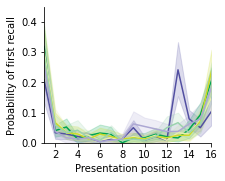

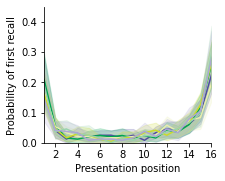

In [ ]:
ylim = [0, 0.45]
combo_lineplot(results['pnr'][1], include_conds=non_adaptive_exclude_random, include_lists='Early', fname='pfr_early_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);
combo_lineplot(results['pnr'][1], include_conds=non_adaptive_exclude_random, include_lists='Late', fname='pfr_late_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);

Transitions

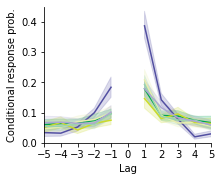

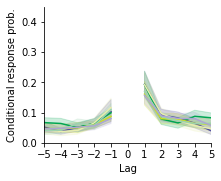

In [ ]:
ylim = [0, 0.45]
combo_lineplot(results['lagcrp'], include_conds=non_adaptive_exclude_random, include_lists='Early', fname='crp_early_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);
combo_lineplot(results['lagcrp'], include_conds=non_adaptive_exclude_random, include_lists='Late', fname='crp_late_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);

Overall performance

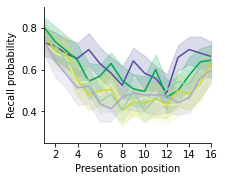

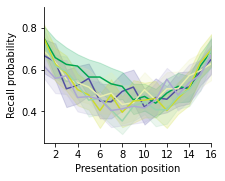

In [ ]:
ylim = [0.25, 0.9]
combo_lineplot(results['spc'], include_conds=non_adaptive_exclude_random, include_lists='Early', fname='spc_early_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);
combo_lineplot(results['spc'], include_conds=non_adaptive_exclude_random, include_lists='Late', fname='spc_late_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);

Event boundaries

loading data..............done!


100%|██████████| 6/6 [04:44<00:00, 47.38s/it]


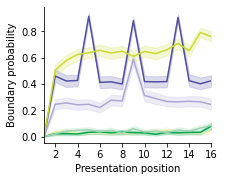

In [ ]:
n_stddev = 1
boundaries, accuracy_near_boundaries = get_boundaries(n_stddev)

# use 1-indexing instead of 0-indexing for presentation position, per reviewer request
for cond, features in boundaries.items():
    for feature, v in features.items():
        x = v.copy()
        x.columns = pd.RangeIndex(v.columns.start + 1, v.columns.stop + 1, v.columns.step)
        boundaries[cond][feature] = x

fig = plt.figure(figsize=(3, 2.5))

for cond in non_adaptive_exclude_random:
    df = boundaries[cond][cond].reset_index().melt(id_vars=['Subject', 'List'], var_name='Presentation position', value_name='Boundary probability')
    sns.lineplot(data=df, x='Presentation position', y='Boundary probability', color=colors[cond]);

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim([1, 16])
ax.set_xticks(range(2, 17, 2))

plt.savefig(os.path.join(figdir, 'boundary_probabilities.pdf'), bbox_inches='tight')

## Figure 4: Memory "fingerprints" (order manipulation conditions)

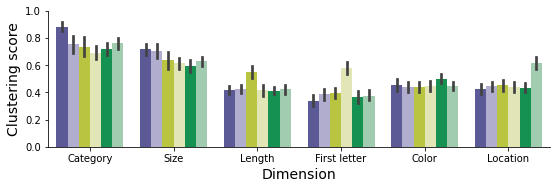

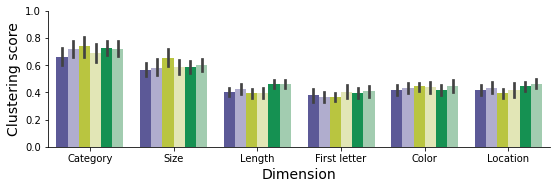

In [ ]:
ylim = [0.0, 1.0]
combo_fingerprint_plot(results['fingerprint'], include_conds=non_adaptive_exclude_random, include_lists='Early', fname='fingerprint_early_nonadaptive', ylim= ylim, figsize=(9, 2.5));
combo_fingerprint_plot(results['fingerprint'], include_conds=non_adaptive_exclude_random, include_lists='Late', fname='fingerprint_late_nonadaptive', ylim=ylim, figsize=(9, 2.5));

## Figure 5: Recall probability and clustering scores on early and late lists

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Category_Early vs. Category_Late: t-test independent samples with Benjamini-Hochberg correction, P_val:5.040e-03 t=2.916e+00
Feature rich_Early vs. Category_Early: t-test independent samples with Benjamini-Hochberg correction, P_val:3.112e-03 t=-3.034e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Category_Early vs. Category_Late: t-test independent samples with Benjamini-Hochberg correction, P_val:3.878e-09 t=6.928e+00
Size_Early vs. Size_Late: t-test independent samples with Benjamini-Hochberg correction, P_val:1.531e-03 t=3.326e+00
Feature rich_Early vs. Category_Early: t-test independent samples with Benjamini-Hochberg correction, P_val:5.036e-12 

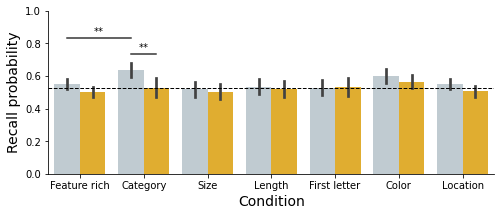

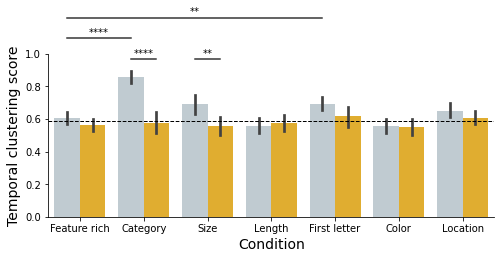

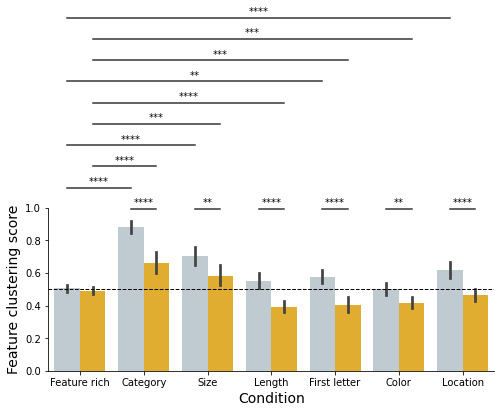

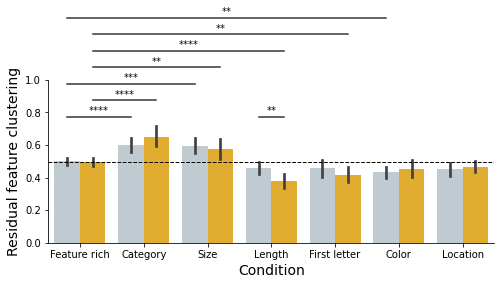

In [ ]:
clustering_results = create_clustering_df(results)

barplot_helper(clustering_results, y='Recall probability', hue='List', palette=[colors['early'], colors['late']], width=8, height=3,
               ref='Feature rich', fname='accuracy_by_cond_barplot', ylim=[0.0, 1.0]);
barplot_helper(clustering_results, y='Temporal clustering score', hue='List', palette=[colors['early'], colors['late']], width=8, height=3,
               ref='Feature rich', fname='temporal_clustering_by_cond_barplot', ylim=[0.0, 1.0]);
barplot_helper(clustering_results, y='Feature clustering score', hue='List', palette=[colors['early'], colors['late']], width=8, height=3,
               ref='Feature rich', fname='feature_clustering_by_cond_barplot', ylim=[0.0, 1.0]);
barplot_helper(clustering_results, y='Corrected feature clustering score', hue='List', palette=[colors['early'], colors['late']], width=8, height=3,
               ref='Feature rich', fname='corrected_feature_clustering_by_cond_barplot', ylim=[0.0, 1.0], ylabel='Residual feature clustering');

## Figure 6: Memory fingerprint dynamics (order manipulation conditions)

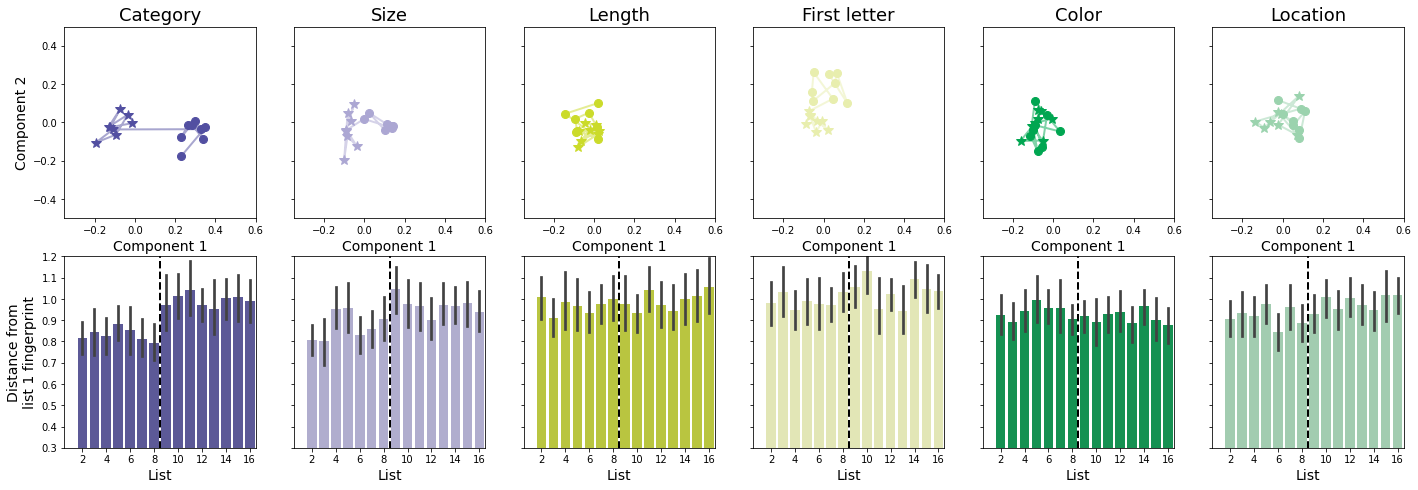

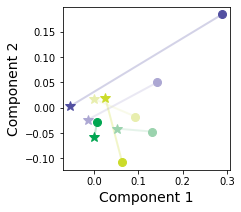

In [ ]:
non_adaptive = sort_by_grouping([*random, *non_adaptive_exclude_random], feature_groupings)
average_early_fingerprints = average_by_cond(results['fingerprint'], include_conds=non_adaptive, include_lists='Early')
average_late_fingerprints = average_by_cond(results['fingerprint'], include_conds=non_adaptive, include_lists='Late')

pca = PCA(n_components=2)
pca.fit(pd.concat([average_early_fingerprints, average_late_fingerprints], axis=0));

early_fingerprints_lowD = pd.DataFrame(pca.transform(average_early_fingerprints), index=average_early_fingerprints.index)
late_fingerprints_lowD = pd.DataFrame(pca.transform(average_late_fingerprints), index=average_late_fingerprints.index)

xlim = [[-0.35, 0.6], [-0.5, 15.5]]
ylim = [[-0.5, 0.5], [0.3, 1.2]]

plot_trajectories(results_by_list['fingerprint'], include_conds=non_adaptive_exclude_random, fname='feature_clustering_trajectories_nonadaptive', xlim=xlim, ylim=ylim);
plot_features(early_fingerprints_lowD, late_fingerprints_lowD, non_adaptive_exclude_random, fname='clustering_pca_nonadaptive_nonrandom')

## Figure 7: Interactions between feature clustering, recall probability, and contiguity

Note: each panel and inset are generated separately

A

xlabel: Clustering score, ylabel: Recall probability


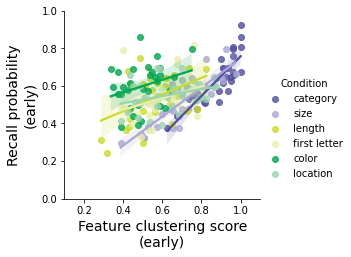

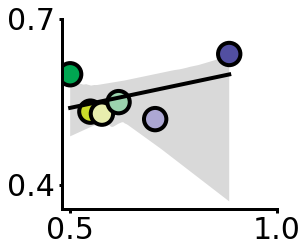

In [ ]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', ylabel='Recall probability\n(early)', xlabel='Feature clustering score\n(early)', x='fingerprint', y='accuracy', fname='clustering_vs_accuracy_scatterplot_early', xlim=[0.1, 1.1], ylim=[0, 1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='accuracy', average=True, fname='ave_clustering_vs_accuracy_scatterplot_early');

B

xlabel: Clustering score, ylabel: Recall probability


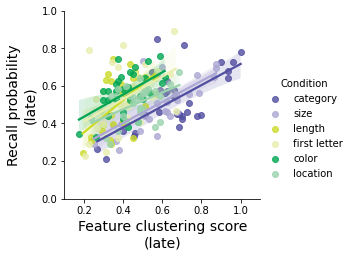

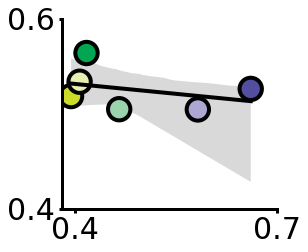

In [ ]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', x='fingerprint', y='accuracy', xlabel='Feature clustering score\n(late)', ylabel='Recall probability\n(late)', fname='clustering_vs_accuracy_scatterplot_late', xlim=[0.1, 1.1], ylim=[0, 1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', x='fingerprint', y='accuracy', average=True, fname='ave_clustering_vs_accuracy_scatterplot_late');

C

xlabel: Clustering score (early), ylabel: Recall probability (late)


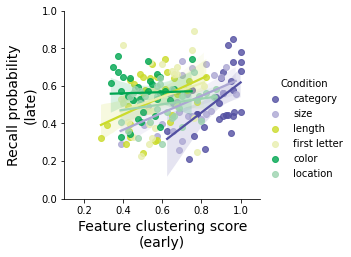

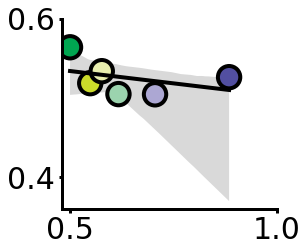

In [ ]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Early', y_lists='Late', x='fingerprint', y='accuracy', fname='clustering_vs_accuracy_scatterplot_late_vs_early',
   xlabel='Feature clustering score\n(early)', ylabel='Recall probability\n(late)', xlim=[0.1, 1.1], ylim=[0, 1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Early', y_lists='Late', x='fingerprint', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_late_vs_early',
   xlabel='Clustering score (early)', ylabel='Recall probability (late)');

D

xlabel: Clustering score (late), ylabel: Recall probability (early)


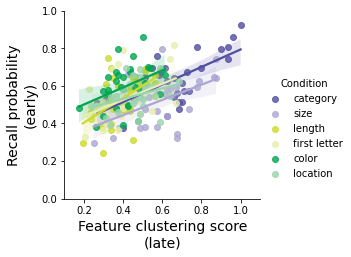

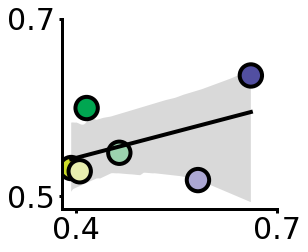

In [ ]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='accuracy', fname='clustering_vs_accuracy_scatterplot_early_vs_late',
   xlabel='Feature clustering score\n(late)', ylabel='Recall probability\n(early)', xlim=[0.1, 1.1], ylim=[0, 1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_early_vs_late',
   xlabel='Clustering score (late)', ylabel='Recall probability (early)');

E

Note that there's a strange "bug" for this panel's inset: the inset's y-axis scale changes very slightly when you re-run the code.  The version used in the paper can be generated by running the code in the following cell twice.  (Both versions are "correct" and are identical other than having slightly different automatically generated y-limits for the inset plot.)

xlabel: Feature clustering score, ylabel: Temporal clustering score


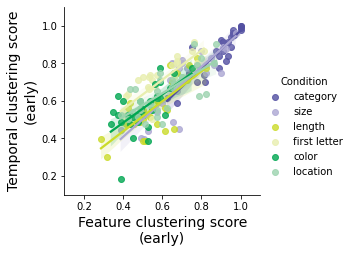

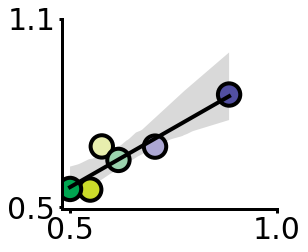

In [ ]:
results['temporal'] = {c: fingerprint2temporal(f) for c, f in results['fingerprint'].items()}
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_early',
                                    xlim=[0.1, 1.1], ylim=[0.1, 1.1], ylabel='Temporal clustering score\n(early)', xlabel='Feature clustering score\n(early)');
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='temporal', average=True, fname='ave_clustering_vs_temporal_scatterplot_early',
                                    ylabel='Temporal clustering score', xlabel='Feature clustering score');                                                                                                    

F

xlabel: Feature clustering score, ylabel: Temporal clustering score


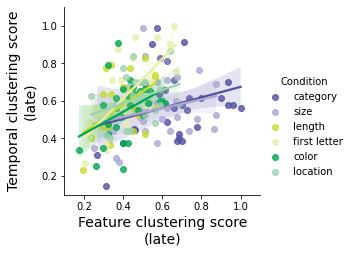

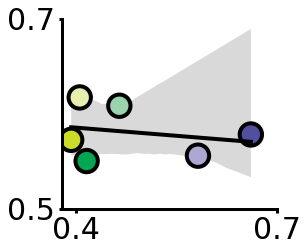

In [ ]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_late',
                                    xlim=[0.1, 1.1], ylim=[0.1, 1.1], ylabel='Temporal clustering score\n(late)', xlabel='Feature clustering score\n(late)');
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', x='fingerprint', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_late',
                                    ylabel='Temporal clustering score', xlabel='Feature clustering score');

G

xlabel: Feature clustering score
(early), ylabel: Temporal clustering score
(late)


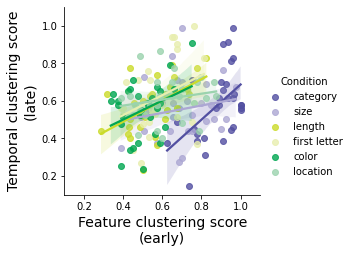

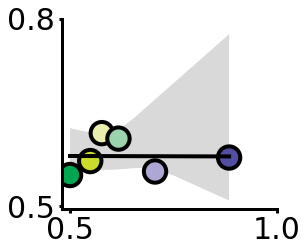

In [ ]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Early', y_lists='Late', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_late_vs_early',
   xlabel='Feature clustering score\n(early)', ylabel='Temporal clustering score\n(late)', xlim=[0.1, 1.1], ylim=[0.1, 1.1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Early', y_lists='Late', x='fingerprint', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_late_vs_early',
   xlabel='Feature clustering score\n(early)', ylabel='Temporal clustering score\n(late)');

H

xlabel: Feature clustering score
(late), ylabel: Temporal clustering score
(early)


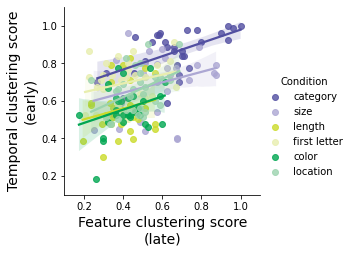

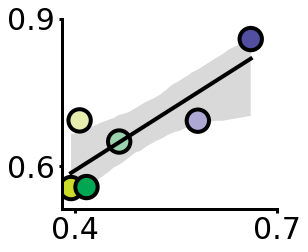

In [ ]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_early_vs_late',
   xlabel='Feature clustering score\n(late)', ylabel='Temporal clustering score\n(early)', xlim=[0.1, 1.1], ylim=[0.1, 1.1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_early_vs_late',
   xlabel='Feature clustering score\n(late)', ylabel='Temporal clustering score\n(early)');

## Figure 8: Feature clustering carryover effects

Note: each panel and inset are generated separately

A

xlabel: Clustering score (late), ylabel: Clustering score (early)


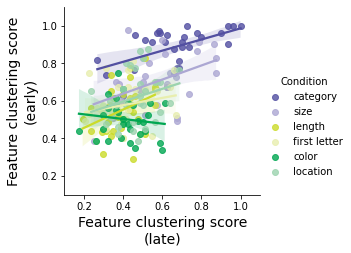

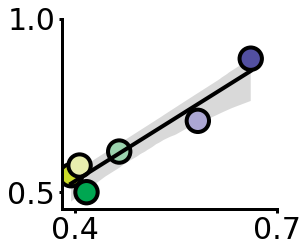

In [ ]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='fingerprint', fname='feature_clustering_scatterplot_early_vs_late',
   ylabel='Feature clustering score\n(early)', xlabel='Feature clustering score\n(late)', xlim=[0.1, 1.1], ylim=[0.1, 1.1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='fingerprint', average=True, fname='ave_feature_clustering_scatterplot_early_vs_late',
   ylabel='Clustering score (early)', xlabel='Clustering score (late)');

B

xlabel: Feature clustering score
(early - late), ylabel: Recall probability
(early - late)


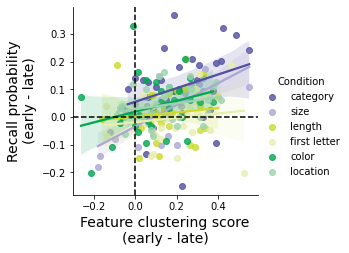

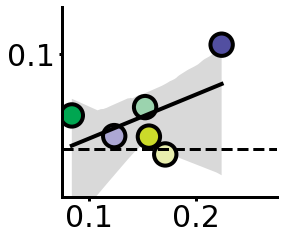

In [ ]:
accuracy_diffs = get_diffs(results['accuracy'], contrast={'Early': 'Late'}, include_conds=non_adaptive_exclude_random)['Early - Late']
fingerprint_diffs = get_diffs(results['fingerprint'], contrast={'Early': 'Late'}, include_conds=non_adaptive_exclude_random)['Early - Late']

fingerprint_scatterplot_by_category({'accuracy': accuracy_diffs, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='accuracy', fname='clustering_vs_accuracy_scatterplot_diffs',
    xlabel='Feature clustering score\n(early - late)', ylabel='Recall probability\n(early - late)');
fingerprint_scatterplot_by_category({'accuracy': accuracy_diffs, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_diffs',
    xlabel='Feature clustering score\n(early - late)', ylabel='Recall probability\n(early - late)', ylim=[-0.05, 0.15], xlim=[0.075, 0.275]);   

C

xlabel: Feature clustering score
(early - late), ylabel: Temporal clustering score
(early - late)


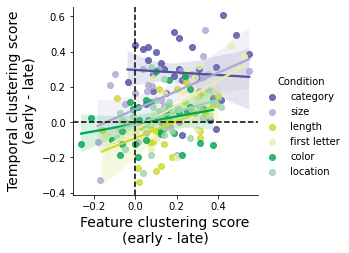

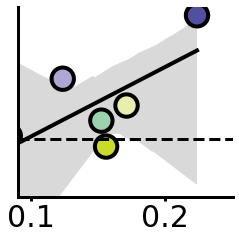

In [ ]:
fingerprint_scatterplot_by_category({'temporal': {c: fingerprint2temporal(f) for c, f in fingerprint_diffs.items()}, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_diffs',
    xlabel='Feature clustering score\n(early - late)', ylabel='Temporal clustering score\n(early - late)');
fingerprint_scatterplot_by_category({'temporal': {c: fingerprint2temporal(f) for c, f in fingerprint_diffs.items()}, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_diffs',
    xlabel='Feature clustering score\n(early - late)', ylabel='Temporal clustering score\n(early - late)', xlim=[0.09, 0.25], ylim=[-0.13, 0.3]);

## Figure 9: Adaptive free recall

A

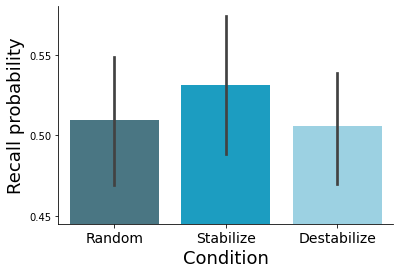

In [ ]:
df = results['accuracy']['adaptive'].data.reset_index().melt(id_vars=['Subject', 'List'], value_name='Recall probability').rename({'List': 'Condition'}, axis=1).drop('variable', axis=1)
sns.barplot(data=df, x='Condition', y='Recall probability', palette=[colors['random'], colors['stabilize'], colors['destabilize']], order=['random', 'stabilize', 'destabilize'])
plt.ylim([0.445, 0.58])

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()], rotation=0, fontsize=14)
ax.set_yticks([0.45, 0.5, 0.55])

plt.ylabel('Recall probability', fontsize=18)
plt.xlabel('Condition', fontsize=18)

plt.savefig(os.path.join(figdir, 'accuracy_adaptive.pdf'), bbox_inches='tight')

B

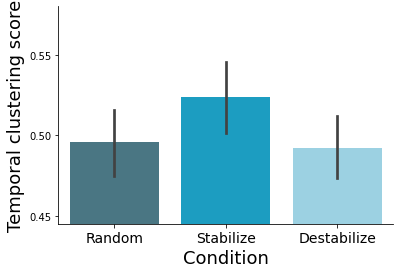

In [ ]:
df = results['fingerprint']['adaptive'].data.reset_index().melt(id_vars=['Subject', 'List'], value_name='temporal').rename({'List': 'Condition'}, axis=1).drop('variable', axis=1)
sns.barplot(data=df, x='Condition', y='temporal', palette=[colors['random'], colors['stabilize'], colors['destabilize']], order=['random', 'stabilize', 'destabilize'])
plt.ylim([0.445, 0.58])

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()], rotation=0, fontsize=14)
ax.set_yticks([0.45, 0.5, 0.55])

plt.ylabel('Temporal clustering score', fontsize=18)
plt.xlabel('Condition', fontsize=18)

plt.savefig(os.path.join(figdir, 'contiguity_adaptive.pdf'), bbox_inches='tight')

C

xlabel: Temporal clustering score, ylabel: Recall probability


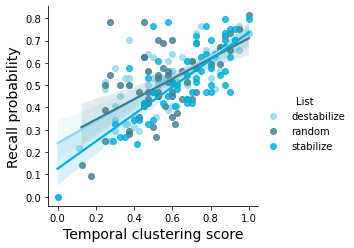

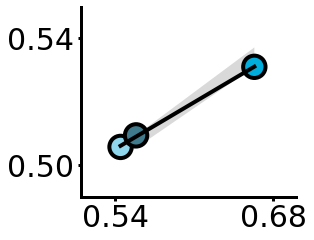

In [ ]:
# create a single dataframe with the following columns:
#   - subject
#   - list type (random, stabilize, or destabilize)
#   - recall probability
#   - temporal clustering score

df = results['accuracy']['adaptive'].data.reset_index().query('List not in ["init"]').rename({0: 'Recall probability'}, axis=1)
df['Temporal clustering score'] = results['fingerprint']['adaptive'].data.reset_index().query('List not in ["init"]')['temporal']

sns.lmplot(data=df, x='Temporal clustering score', y='Recall probability', hue='List', palette=[colors[c] for c in ['destabilize', 'random', 'stabilize']], height=3.5, aspect=1.1)

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.xlabel(ax.get_xlabel(), fontsize=14)
plt.ylabel(ax.get_ylabel(), fontsize=14)

plt.savefig(os.path.join(figdir, 'scatterplot_accuracy_vs_contiguity_adaptive.pdf'), bbox_inches='tight')

fig = plt.figure(figsize=(1.1 * 3.5, 3.5))
sns.regplot(data=df.groupby('List').mean(), y='Recall probability', x='Temporal clustering score', color='k', marker='.', scatter_kws={'s': 0.1}, line_kws={'linewidth': 4})
sns.scatterplot(data=df.groupby('List').mean().reset_index(), y='Recall probability', x='Temporal clustering score', hue='List', palette=[colors[c] for c in ['destabilize', 'random', 'stabilize']], legend=False, s=500, edgecolor='k', linewidth=4)

# get rid of all tick labels except second and last, increase font size
ax = plt.gca()        
ax.set_xticks([np.round(ax.get_xticks()[1], decimals=2), np.round(ax.get_xticks()[-1], decimals=2)])
ax.set_yticks([np.round(ax.get_yticks()[1], decimals=2), np.round(ax.get_yticks()[-1], decimals=2)])
ax.tick_params(axis='both', which='major', labelsize=30)
plt.setp(ax.spines.values(), linewidth=3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

print('xlabel: {xlabel}, ylabel: {ylabel}'.format(xlabel=ax.get_xlabel(), ylabel=ax.get_ylabel()))
ax.set_xlabel('')
ax.set_ylabel('')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim([0.51, 0.7])
plt.ylim([0.49, 0.55])

plt.savefig(os.path.join(figdir, 'average_scatterplot_accuracy_vs_contiguity_adaptive.pdf'), bbox_inches='tight')

D

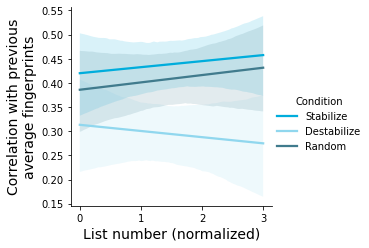

In [ ]:
fingerprints = results_by_list['fingerprint']['adaptive'].data.reset_index()

# start by creating a dataframe just for the distances of the current list's fingerprint to the average of the previous lists
def get_corrs_to_average_previous(fingerprints):
    features = ['category', 'size', 'length', 'first_letter', 'color', 'pos']
    fingerprints = fingerprints[features]
    corrs = [0]
    for i in range(1, len(fingerprints)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            corrs.append(np.corrcoef(fingerprints.iloc[i], fingerprints.iloc[:i].mean())[0, 1])
    return np.array(corrs)


fingerprint_corrs = {'stabilize': [], 'destabilize': [], 'random': []}
for subj in fingerprints.Subject.unique():
    x = fingerprints[fingerprints.Subject == subj].copy()
    x['Condition'] = listgroups['adaptive'][subj]
    x['Correlation with previous average'] = get_corrs_to_average_previous(x)
    for cond in fingerprint_corrs.keys():
        x_cond = x.query('Condition == @cond').copy()        
        x_cond['Normalized list number'] = x_cond['List'].apply(lambda x: x - x_cond['List'].min())
        fingerprint_corrs[cond].append(x_cond)

for cond in fingerprint_corrs.keys():
    fingerprint_corrs[cond] = pd.concat(fingerprint_corrs[cond], axis=0)

# combine dataframes
fingerprint_corrs = pd.concat(fingerprint_corrs.values(), axis=0)
fingerprint_corrs['Condition'] = fingerprint_corrs['Condition'].apply(lambda x: x.capitalize())

sns.lmplot(fingerprint_corrs, x='Normalized list number', y='Correlation with previous average', hue='Condition', palette=[colors[c.lower()] for c in fingerprint_corrs['Condition'].unique()], scatter=False, height=3.5, aspect=1.1)
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_xlabel('List number (normalized)', fontsize=14)
ax.set_ylabel('Correlation with previous\naverage fingerprints', fontsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gcf().savefig(os.path.join(figdir, 'adaptive_fingerprint_corrs_by_list.pdf'), bbox_inches='tight')

# Supplemental figures

For figure descriptions, see the [supplemental materials](https://osf.io/j4xqk/).

## Figure S1: Recall dynamics in feature rich free recall (random conditions)

Recall initiation

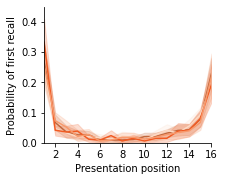

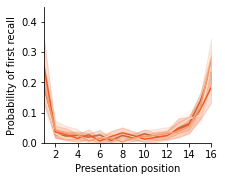

In [ ]:
ylim = [0, 0.45]
combo_lineplot(results['pnr'][1], include_conds=random, include_lists='Early', fname='pfr_early_random', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);
combo_lineplot(results['pnr'][1], include_conds=random, include_lists='Late', fname='pfr_late_random', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);

Transitions

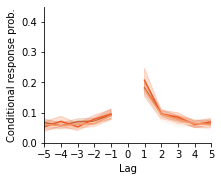

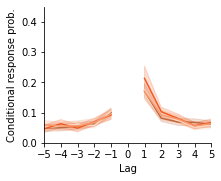

In [ ]:
ylim = [0, 0.45]
combo_lineplot(results['lagcrp'], include_conds=random, include_lists='Early', fname='crp_early_random', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);
combo_lineplot(results['lagcrp'], include_conds=random, include_lists='Late', fname='crp_late_random', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);

Overall performance

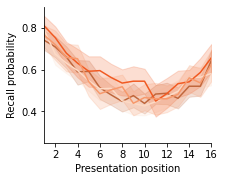

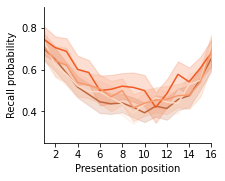

In [ ]:
ylim = [0.25, 0.9]
combo_lineplot(results['spc'], include_conds=random, include_lists='Early', fname='spc_early_random', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);
combo_lineplot(results['spc'], include_conds=random, include_lists='Late', fname='spc_late_random', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);

## Figure S2: Recall dynamics in feature rich free recall (adaptive conditions)

Recall initiation

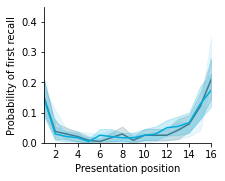

In [ ]:
ylim = [0, 0.45]
combo_lineplot(results['pnr'][1], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='pfr_adaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);

Transitions

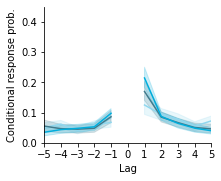

In [ ]:
ylim = [0, 0.45]
combo_lineplot(results['lagcrp'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='crp_adaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);

Overall performance

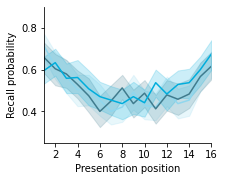

In [ ]:
ylim = [0.25, 0.9]
combo_lineplot(results['spc'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='spc_adaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);

## Figure S3: Recall accuracy by study list number

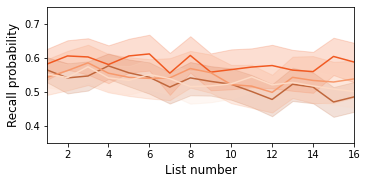

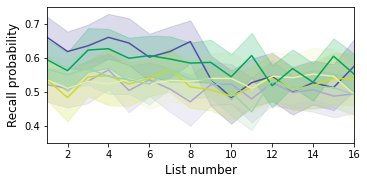

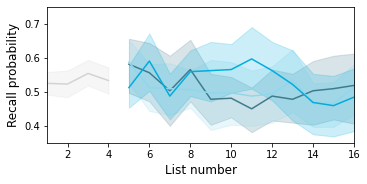

In [ ]:
# non-adaptive conditions: organize by results key
random_accuracy = accuracy2df({c: results_by_list['accuracy'][c] for c in feature_groupings['random']})
nonadaptive_accuracy = accuracy2df({c: results_by_list['accuracy'][c] for c in non_adaptive_exclude_random})

# adaptive conditons: assign manually
adaptive_accuracy = results_by_list['accuracy']['adaptive'].data.reset_index().rename({0: 'Accuracy'}, axis=1)
adaptive_accuracy['Condition'] = adaptive_accuracy.apply(adaptive_listnum2cond, axis=1)

accuracy_by_list(random_accuracy, ylim=[0.35, 0.75], fname='random_accuracy_by_listnum');
accuracy_by_list(nonadaptive_accuracy, ylim=[0.35, 0.75], fname='nonadaptive_accuracy_by_listnum');
accuracy_by_list(adaptive_accuracy, ylim=[0.35, 0.75], fname='adaptive_accuracy_by_listnum');

## Figure S4: Correlations between feature clustering scores (order manipulation conditions)

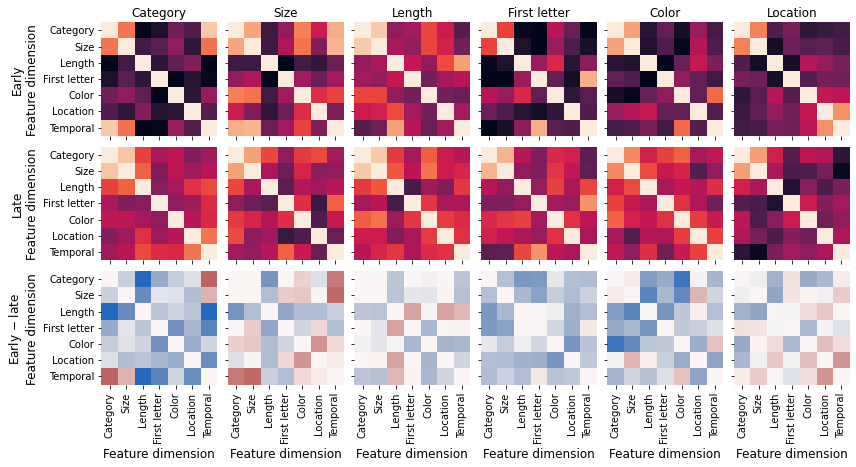

In [ ]:
cluster_mats = clustering_matrices(results['fingerprint'], include_conds=non_adaptive_exclude_random, include_lists='all')
plot_heatmaps(cluster_mats, include_conds=non_adaptive_exclude_random, include_lists='all', contrasts={'Early': 'Late'}, fname='clustering_heatmaps_nonadaptive_nonrandom', vmin=-0.2, vmax=1.0, dvmin=-0.8, dvmax=0.8, fontsize=12, width=2, height=2.2, xlabel='Feature dimension', ylabel='Feature dimension');

In [ ]:
def plot_colorbar(cmap):
    fig = plt.figure(figsize=(0.1, 2))
    ax = fig.add_subplot(111)
    norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
    mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)
    plt.gcf().savefig(os.path.join(figdir, f'{cmap}_legend.pdf'), bbox_inches='tight')

In [ ]:
plot_colorbar('rocket')

In [ ]:
plot_colorbar('vlag')

## Figure S5: Memory "fingerprints" (random conditions)

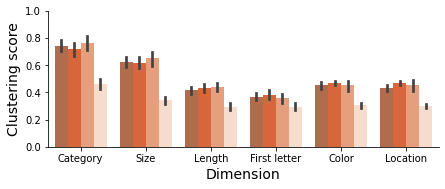

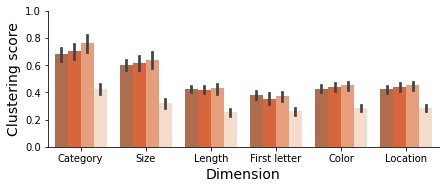

In [ ]:
ylim = [0.0, 1.0]
combo_fingerprint_plot(results['fingerprint'], include_conds=random, include_lists='Early', fname='fingerprint_early_random', ylim= ylim, figsize=(7, 2.5));
combo_fingerprint_plot(results['fingerprint'], include_conds=random, include_lists='Late', fname='fingerprint_late_random', ylim=ylim, figsize=(7, 2.5));

## Figure S6: Memory "fingerprints" (adaptive conditions)

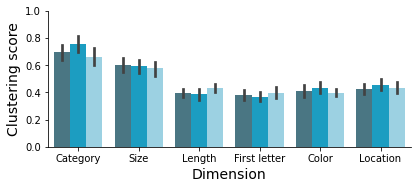

In [ ]:
ylim = [0.0, 1.0]
combo_fingerprint_plot(results['fingerprint'], include_conds=['adaptive'], include_lists=['random', 'stabilize', 'destabilize'], fname='fingerprint_adaptive', ylim=ylim, figsize=(6.5, 2.5));

## Figure S7: Probability of $n^\mathrm{th}$ recall matrices

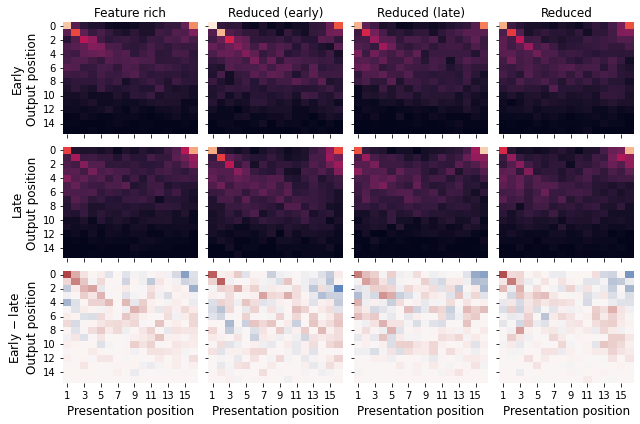

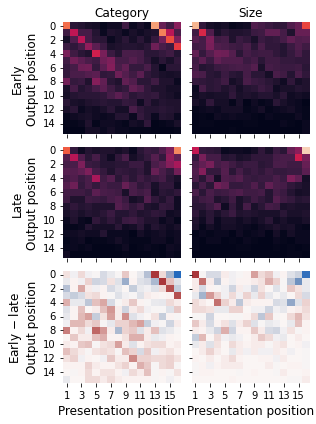

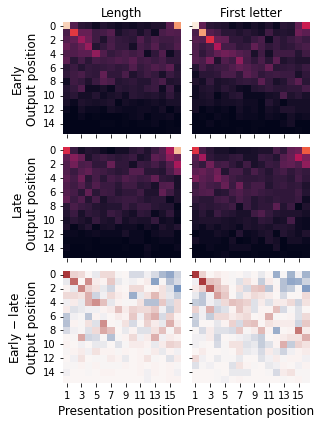

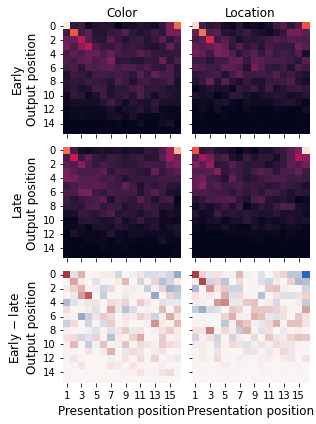

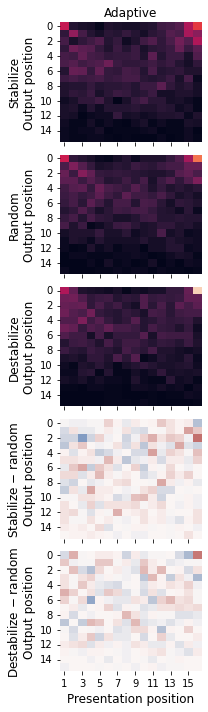

In [ ]:
x = pnr_matrix(results['pnr'], include_conds='all')

# non-adaptive heatmaps
for group, conds in feature_groupings.items():
    if group == 'adaptive':
        continue    

    plot_heatmaps(x, include_conds=conds, contrasts={'Early': 'Late'}, fname=f'pnr_heatmaps_{group}', vmin=0, vmax=0.3, dvmin=-0.1, dvmax=0.1, width=2.25, xlabel='Presentation position', ylabel='Output position')

# adaptive heatmaps´
plot_heatmaps(x, include_conds=['adaptive'], include_lists=['stabilize', 'random', 'destabilize'], contrasts={'stabilize': 'random', 'destabilize': 'random'}, fname='pnr_heatmaps_adaptive', vmin=0, vmax=0.3, dvmin=-0.1, dvmax=0.1, width=3, height=2, xlabel='Presentation position', ylabel='Output position');

## Figure S8: Memory fingerprint dynamics (random conditions)

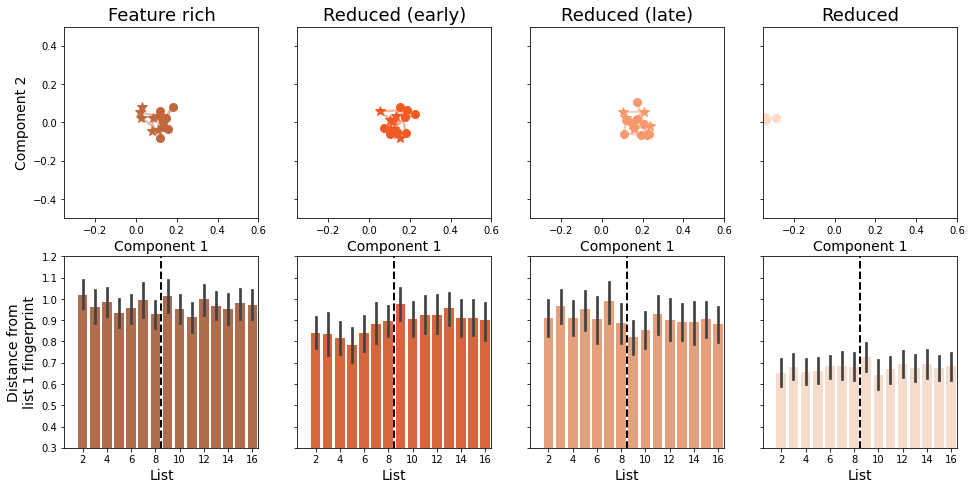

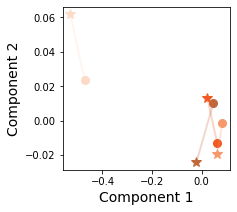

In [ ]:
xlim = [[-0.35, 0.6], [-0.5, 15.5]]
ylim = [[-0.5, 0.5], [0.3, 1.2]]

plot_trajectories(results_by_list['fingerprint'], include_conds=random, fname='feature_clustering_trajectories_random', xlim=xlim, ylim=ylim);
plot_features(early_fingerprints_lowD, late_fingerprints_lowD, random, fname='clustering_pca_random')